In [2]:
import sys
!{sys.executable} -m pip install moviepy

Processing c:\users\evansamaa\appdata\local\pip\cache\wheels\56\dc\2b\9cd600d483c04af3353d66623056fc03faed76b7518faae4df\moviepy-1.0.3-py3-none-any.whl
  Using cached imageio_ffmpeg-0.4.5-py3-none-win_amd64.whl (22.6 MB)
Processing c:\users\evansamaa\appdata\local\pip\cache\wheels\12\36\1f\dc61e6ac10781d63cf6fa045eb09fa613a667384e12cb6e6e0\proglog-0.1.9-py3-none-any.whl


In [1]:
from tqdm import tqdm
import mediapipe as mp
import os
import shutil
import json
import time
from util.ioUtil import *
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt

In [2]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
landmark_output = []
tolerance = 0.001
file = "C:/Users/evansamaa/Desktop/Jali_Experiments/ten_videos/grenade/grenade_3/frame176.jpg"

with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
    imgs_arr = []
    image = cv2.imread(file)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face_landmarks = results.multi_face_landmarks[0].landmark
    land_mark_matrix_pts = np.zeros((468, 3))
    for i in range(0, len(face_landmarks)):
        land_mark_matrix_pts[i, 0] = face_landmarks[i].x
        land_mark_matrix_pts[i, 1] = face_landmarks[i].y
        land_mark_matrix_pts[i, 2] = face_landmarks[i].z
    plane_pts = [land_mark_matrix_pts[98], land_mark_matrix_pts[327], land_mark_matrix_pts[168]]
    # rotate the projected matrix to face the camerra
    n = np.cross(plane_pts[2] - plane_pts[1], plane_pts[0] - plane_pts[1])
    n = n / np.linalg.norm(n)
    R = rotation_matrix_from_vectors(n, np.array([0, 0, 1]))
    rotated_land_marks = np.expand_dims(land_mark_matrix_pts, axis=2)
    R = np.expand_dims(R, axis=0)
    rotated_land_marks = R @ rotated_land_marks
    projected_land_marks = rotated_land_marks[:, 0:2, 0]
    projected_land_marks = projected_land_marks - projected_land_marks[4]
    
    nose_ridge_vector = (projected_land_marks[6, :])
    nose_ridge_vector = nose_ridge_vector / np.linalg.norm(nose_ridge_vector)
    target_nose_ridge_direction = np.array([0, 1])
    abs_angle_diff = np.arccos(np.dot(nose_ridge_vector, target_nose_ridge_direction))
    theta = abs_angle_diff
    r = np.array(((np.cos(theta), -np.sin(theta)),
                  (np.sin(theta), np.cos(theta))))
    diff = np.linalg.norm(r @ nose_ridge_vector - target_nose_ridge_direction)
    if diff >= tolerance:
        theta = - theta
        r = np.array(((np.cos(theta), -np.sin(theta)),
                      (np.sin(theta), np.cos(theta))))
        if np.linalg.norm(r @ nose_ridge_vector - target_nose_ridge_direction) >= diff:
            theta = - theta
            r = np.array(((np.cos(theta), -np.sin(theta)),
                          (np.sin(theta), np.cos(theta))))

    normalized_landmark = np.expand_dims(r, axis=0) @ np.expand_dims(projected_land_marks, axis=2)
    landmark_output = normalized_landmark[:, :, 0]

In [4]:
print(landmark_output.shape)

(468, 2)


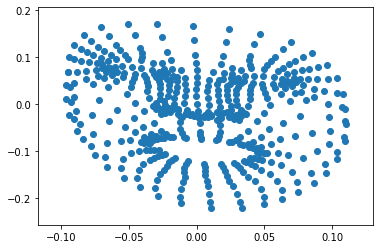

In [19]:
plt.scatter(landmark_output[:,0], landmark_output[:,1])
    # plt.scatter(landmark_arr_i[4, 0], landmark_arr_i[4, 1])
    # plt.scatter(landmark_arr_i[98, 0], landmark_arr_i[98, 1])
    # plt.scatter(landmark_arr_i[327, 0], landmark_arr_i[327, 1])
    # plt.show()
plt.show()

In [6]:
file_mediapipe = "C:\\Users\\evansamaa\\Desktop\\Jali_Experiments\\ten_videos\\I_dont_love_you\\I_dont_love_you_short\\mediapipe_landmark.npy"
file_cv = "C:\\Users\\evansamaa\\Desktop\\Jali_Experiments\\ten_videos\\I_dont_love_you\\I_dont_love_you_short\\cv_landmark.npy"

In [7]:
cv_arr = np.load(file_cv)
mp_arr = np.load(file_mediapipe)

In [9]:
cv_arr_mod = cv_arr/2

    

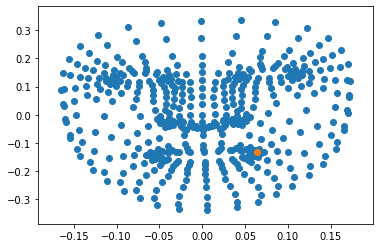

In [27]:
i = 1
k =292
# plt.scatter(cv_arr_mod[i,:,0], cv_arr_mod[i,:,1])
plt.scatter(mp_arr[i,:,0], mp_arr[i,:,1])
plt.scatter(mp_arr[i,k:k+1,0], mp_arr[i,k:k+1,1])

plt.show()

In [ ]:
upp_lip_list = [11, 312, 311, 310, 272, 415, 407, 308, 292
               ]